# Julia's support for scaling projects
- Using Julia's type system
- Defining multiple methods for a function
- Working with modules and packages
- Using macros

Sooner or later you codes base 

## Understanding Julia's type system

- Restricting the types of arguments to a function speeds up the code
- It helps debugging

In [15]:
# One function multiple methods
methods(cd)

# 4 methods for generic function "cd":
[1] cd() in Base.Filesystem at file.jl:94
[2] cd(dir::AbstractString) in Base.Filesystem at file.jl:89
[3] cd(f::Function) in Base.Filesystem at file.jl:147
[4] cd(f::Function, dir::AbstractString) in Base.Filesystem at file.jl:107

In [5]:
deal(a::Int, b::Int) = a + b
deal(a::Float64, b::Float64) = a * b
methods(deal)

# 2 methods for generic function "deal":
[1] deal(a::Int64, b::Int64) in Main at /mnt/w/1t-nvme/projects/Talk-Julia/julia/04-support-for-scaling-projects.ipynb:1
[2] deal(a::Float64, b::Float64) in Main at /mnt/w/1t-nvme/projects/Talk-Julia/julia/04-support-for-scaling-projects.ipynb:2

In [4]:
@show deal(1, 2)
@show deal(1.0, 2.0);
#error → @show deal(1, 2.0)

deal(1, 2) = 3
deal(1.0, 2.0) = 2.0


2.0

In [6]:
@code_llvm deal(1, 2)
@code_llvm deal(1.0, 2.0)

;  @ /mnt/w/1t-nvme/projects/Talk-Julia/julia/04-support-for-scaling-projects.ipynb:1 within `deal`
define i64 @julia_deal_2265(i64 signext %0

, i64 signext %1) #0 {
top:
; ┌ @ int.jl:87 within `+`
   %2 = add i64 %1, %0
; └
  ret i64 %2
}
;  @ /mnt/w/1t-nvme/projects/Talk-Julia/julia/04-support-for-scaling-projects.ipynb:2 within `deal`
define double @julia_deal_2286(double %0, double %1) #0 {
top:
; ┌ @ float.jl:385 within `*`
   %2 = fmul double %0, %1
; └
  ret double %2
}


In [8]:
supertype(typeof(deal))

Function

- Julia types are organized in a hierarchy tree
- Any is the root of the tree

```julia
subtypes(Function); # → ~13402 function instances
subtypes(Any);      # → ~646 elements
supertype(Any);     # → Any
supertypes(Any);    # → (Any,)
typeof(deal);       # → singleton type of function deal, subtype of Function
```

- Concrete types are the leaves of the tree, which can be instantiated
- Abstract types are the nodes of the tree, which only serve as intermediate types allowing to group other types

In [11]:
# Find all supertypes
function print_supertypes(T)
    println(T)
    T == Any || print_supertypes(supertype(T))
    return nothing
end

print_supertypes (generic function with 1 method)

In [12]:
print_supertypes(Int64)

Int64
Signed
Integer
Real
Number
Any


In [13]:
# Find all subtypes
function print_subtypes(T, indent_level = 0)
    println(" " ^ indent_level, T)
    for S in subtypes(T)
        print_subtypes(S, indent_level + 2)
    end
    return nothing
end

print_subtypes (generic function with 2 methods)

In [14]:
print_subtypes(Integer)

Integer


  Bool
  Signed
    BigInt
    Int128
    Int16
    Int32
    Int64
    Int8
  Unsigned
    UInt128
    UInt16
    UInt32
    UInt64
    UInt8


In [16]:
# Use `Union` to specify multiple types with no respective node
Union{Int64, Float64}
Union{String, Missing}

Union{Missing, String}

In [18]:
# Decide what types to use to restrict the input
print_supertypes(typeof([1.0, 2.0, 3.0]))
println()
print_supertypes(typeof(1:3))

Vector{Float64}
DenseVector{Float64}
AbstractVector{Float64}
Any

UnitRange{Int64}
AbstractUnitRange{Int64}
OrdinalRange{Int64, Int64}
AbstractRange{Int64}
AbstractVector{Int64}
Any


In [19]:
# we can see above two types seem to join at `AbstractArray`
typejoin(typeof([1.0, 2.0, 3.0]), typeof(1:3)) # built-in function

AbstractVector (alias for AbstractArray{T, 1} where T)

## Using multiple dispatch

In [20]:
func(x) = println("Unsupported type")
func(x::Number) = println("A number was passed")
func(x::Float64) = println("A Float64 was passed")
methods(func)

# 3 methods for generic function "func":
[1] func(x::Float64) in Main at /mnt/w/1t-nvme/projects/Talk-Julia/julia/04-support-for-scaling-projects.ipynb:3
[2] func(x::Number) in Main at /mnt/w/1t-nvme/projects/Talk-Julia/julia/04-support-for-scaling-projects.ipynb:2
[3] func(x) in Main at /mnt/w/1t-nvme/projects/Talk-Julia/julia/04-support-for-scaling-projects.ipynb:1

In [21]:
func("hello")
func(1)
func(1.0)

Unsupported type
A number was passed
A Float64 was passed


In [22]:
# Avoid ambiguity
bar(x, y) = println("No number passed")
#bar(x::Number, y::Number) = println("Two numbers passed")
bar(x::Number, y) = println("first argument is a number")
bar(x, y::Number) = println("second argument is a number")
bar("hello", "world")
bar(1, "world")
bar("hello", 2)
bar(1, 2)

No number passed
first argument is a number
second argument is a number


MethodError: MethodError: bar(::Int64, ::Int64) is ambiguous. Candidates:
  bar(x::Number, y) in Main at /mnt/w/1t-nvme/projects/Talk-Julia/julia/04-support-for-scaling-projects.ipynb:4
  bar(x, y::Number) in Main at /mnt/w/1t-nvme/projects/Talk-Julia/julia/04-support-for-scaling-projects.ipynb:5
Possible fix, define
  bar(::Number, ::Number)

## Working with packages

- Functions are shared using packages in Julia world
    - together with their environmental dependencies
- `module`s are a way to define separate namespaces
    - e.g., variable `a` in module `x` and `y` are independent, i.e., `x.a` and `y.a`

- Understand
    - module
    - package
    - file
    - functions

In [23]:
module exampleModule

function example() # note no indenting here
    println("This is the example function")
end

end # exampleModule

Main.exampleModule

In [24]:
exampleModule.example()

This is the example function


- Optional
    - create a package
    - publish a package
    - register a package to share
- to use a package

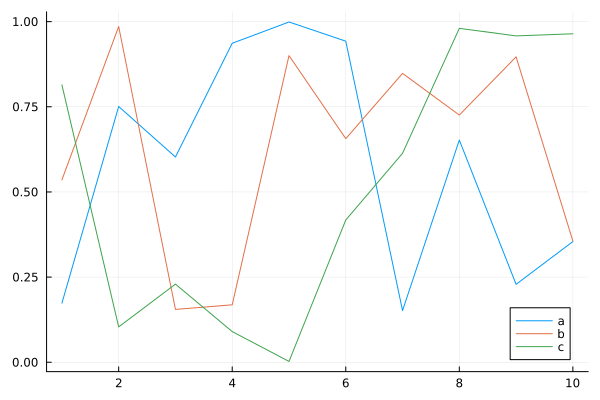

In [25]:
using Plots
plot(1:10, rand(10, 3), label = ["a" "b" "c"])

- `import` vs `using`
    - `import` only imports the module
    - `using` imports the module and all its exported functions

## Using macros

In [26]:
@time 1 + 2
@time(1 + 2)

  0.000001 seconds
  0.000000 seconds


3

In [27]:
@assert 1 == 2 "1 is not equal to 2"

AssertionError: AssertionError: 1 is not equal to 2

In [28]:
@macroexpand @assert 1 == 2 "1 is not equal to 2"

:(if 1 == 2
      nothing
  else
      Base.throw(Base.AssertionError("1 is not equal to 2"))
  end)

In [31]:
using BenchmarkTools
x = rand(10^6)
@benchmark mean(x)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  90.180 μs … 345.853 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     92.381 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   92.908 μs ±   3.144 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▁▁▃▅▇████▇▆▆▅▄▂        ▁▂▁▂▂▁▁▁▁▁                        ▃
  ▄▄▆█████████████████▆▆▆▅▆▇██████████████▇███▇▇▇▆▇▆▆▅▄▅▅▅▅▆▇▆ █
  90.2 μs       Histogram: log(frequency) by time       101 μs <

 Memory estimate: 16 bytes, allocs estimate: 1.

## Summary

- types is hierarchical, and form a tree
- single function can have multiple methods
- `module` is a way to define separate namespaces
    - usually to create a package
- Macros allow you to transform code into other code before it is executed
    - see [julia docs](https://docs.julialang.org/en/v1/manual/metaprogramming/#man-macros)
- Julia is batteries included, or many packages are available
